In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import sys
import seaborn as sns
import numpy as np
from scipy import ndimage


sys.path.append('../../shared')
from file_analyzer import FileAnalyzer


# Analyze your file
analyzer = FileAnalyzer('../../../data/independent_expenditure_2024.csv')
analyzer.print_summary()

# Get the DataFrame
df = analyzer.get_dataframe()

# Sort by filer (spe_id), date (exp_date), and candidate (cand_id)
df_clean = df.sort_values(['spe_id', 'exp_date', 'cand_id', 'file_num'])

# Remove duplicates keeping the latest file (amended reports)
df_clean = df_clean.drop_duplicates(subset=['spe_id', 'exp_date', 'cand_id', 'exp_amo'], keep='last')

df = df_clean

# https://www.fec.gov/campaign-finance-data/independent-expenditures-file-description/




FILE ANALYSIS SUMMARY
📁 File: independent_expenditure_2024.csv
📊 Type: CSV
💾 Size: 18.6 MB
📈 Shape: (73403, 23)
🔢 Columns: 23
📋 Rows: 73403


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53998 entries, 1997 to 2868
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cand_id           47413 non-null  object 
 1   cand_name         53998 non-null  object 
 2   spe_id            53998 non-null  object 
 3   spe_nam           53995 non-null  object 
 4   ele_type          53998 non-null  object 
 5   can_office_state  45107 non-null  object 
 6   can_office_dis    53979 non-null  float64
 7   can_office        53985 non-null  object 
 8   cand_pty_aff      46476 non-null  object 
 9   exp_amo           53998 non-null  float64
 10  exp_date          35879 non-null  object 
 11  agg_amo           53914 non-null  float64
 12  sup_opp           53957 non-null  object 
 13  pur               53989 non-null  object 
 14  pay               53998 non-null  object 
 15  file_num          53998 non-null  int64  
 16  amndt_ind         53998 non-null  object 
 

In [23]:
pd.set_option('display.max_columns', None)
# df.head()
df['cand_pty_aff'].value_counts()
# df[df['cand_name'].str.contains('Nate') & (df['exp_amo'] >= 123) & (df['exp_amo'] <= 20000)]
# df[df['exp_amo'] >= 8000000]

cand_pty_aff
DEMOCRATIC PARTY           23818
REPUBLICAN PARTY           21799
INDEPENDENT                  572
DEMOCRATIC-FARMER-LABOR      163
LIBERTARIAN PARTY             54
OTHER                         28
GREEN PARTY                   22
UNKNOWN                       16
UNAFFILIATED                   4
Name: count, dtype: int64

In [24]:
candidate_counts = df['cand_name'].value_counts()

print(f"Total number of distinct candidates: {len(candidate_counts)}")
print(f"\nTop 20 candidates by number of expenditures:")
print(candidate_counts.head(20))


Total number of distinct candidates: 1296

Top 20 candidates by number of expenditures:
cand_name
Harris, Kamala        5205
Trump, Donald         3225
HARRIS, KAMALA        2925
TRUMP, DONALD         1710
TRUMP, DONALD J.      1050
GALLEGO, RUBEN         913
SUAREZ, FRANCIS X.     821
HALEY, NIKKI           559
SHEEHY, TIM            541
BROWNLEY, JULIA        461
BILIRAKIS, GUS         459
ROSEN, JACKY           443
MORENO, BERNIE         441
BALDWIN, TAMMY         435
Baldwin, Tammy         419
SHAH, AMISH            376
ENGEL, KIRSTEN         370
BROWN, SAM             370
Biden, Joseph          339
RUTHERFORD, JOHN       333
Name: count, dtype: int64


In [25]:
print("Summary statistics:")
print(f"Total expenditures: {len(df)}")
print(f"Unique candidates: {df['cand_name'].nunique()}")
print(f"Average expenditures per candidate: {len(df) / df['cand_name'].nunique():.2f}")

print(f"\nCandidates with most expenditures:")
print(candidate_counts.head(10))

print(f"\nCandidates with least expenditures (appearing only once):")
single_occurrence = candidate_counts[candidate_counts == 1]
print(f"Number of candidates appearing only once: {len(single_occurrence)}")
print(single_occurrence.head(10))


Summary statistics:
Total expenditures: 53998
Unique candidates: 1296
Average expenditures per candidate: 41.67

Candidates with most expenditures:
cand_name
Harris, Kamala        5205
Trump, Donald         3225
HARRIS, KAMALA        2925
TRUMP, DONALD         1710
TRUMP, DONALD J.      1050
GALLEGO, RUBEN         913
SUAREZ, FRANCIS X.     821
HALEY, NIKKI           559
SHEEHY, TIM            541
BROWNLEY, JULIA        461
Name: count, dtype: int64

Candidates with least expenditures (appearing only once):
Number of candidates appearing only once: 230
cand_name
Shankland, Katrina        1
BAECHLER, MARY            1
Kamala, Harris            1
Espaillat, Adriano        1
Mundy, Keith              1
Boyd, Cherissa            1
Uncomitted, Uncomitted    1
kaine, Timothy            1
Adam, Gray                1
DAVE, MCCORMICK           1
Name: count, dtype: int64


In [26]:
spender_counts = df['spe_nam'].value_counts()

print(f"Total number of distinct spenders: {len(spender_counts)}")
print(f"\nTop 20 spenders by number of expenditures:")
print(spender_counts.head(20))

Total number of distinct spenders: 1074

Top 20 spenders by number of expenditures:
spe_nam
Americans for Prosperity Action, Inc. (AFP Action) DBA CVA Action and DBA LIBRE Action    2280
Congressional Leadership Fund                                                             1609
Worker Power                                                                              1485
SENATE CONSERVATIVES FUND                                                                 1367
RED SENATE                                                                                1279
SUPPORT AMERICA'S POLICE PAC                                                              1121
HMP                                                                                       1012
Republican Accountability PAC                                                              972
SOS AMERICA PAC                                                                            825
Working America                                      

In [27]:
# Examine the four key columns
columns_to_examine = ['spe_nam', 'cand_pty_aff', 'pur', 'exp_amo']

print("Column Information:")
print("=" * 50)
for col in columns_to_examine:
    print(f"\n{col}:")
    print(f"  Data type: {df[col].dtype}")
    print(f"  Non-null count: {df[col].notna().sum()}")
    print(f"  Null count: {df[col].isna().sum()}")
    print(f"  Unique values: {df[col].nunique()}")
    
    if col == 'exp_amo':
        print(f"  Min value: ${df[col].min():,.2f}")
        print(f"  Max value: ${df[col].max():,.2f}")
        print(f"  Mean value: ${df[col].mean():,.2f}")
        print(f"  Median value: ${df[col].median():,.2f}")
    else:
        print(f"  Sample values: {df[col].dropna().head(5).tolist()}")


Column Information:

spe_nam:
  Data type: object
  Non-null count: 53995
  Null count: 3
  Unique values: 1074
  Sample values: ['AMERICAN MEDICAL ASSOCIATION POLITICAL ACTION COMMITTEE', 'AMERICAN MEDICAL ASSOCIATION POLITICAL ACTION COMMITTEE', 'DCCC', 'DCCC', 'DCCC']

cand_pty_aff:
  Data type: object
  Non-null count: 46476
  Null count: 7522
  Unique values: 9
  Sample values: ['DEMOCRATIC PARTY', 'REPUBLICAN PARTY', 'REPUBLICAN PARTY', 'REPUBLICAN PARTY', 'REPUBLICAN PARTY']

pur:
  Data type: object
  Non-null count: 53989
  Null count: 9
  Unique values: 5450
  Sample values: ['Media Buy and Production', 'Media Buy and Production', 'Digital Media -  Production Estimate', 'Digital Media -  Production Estimate', 'Media Production - Estimate']

exp_amo:
  Data type: float64
  Non-null count: 53998
  Null count: 0
  Unique values: 30221
  Min value: $-580,000.00
  Max value: $9,978,412,568.00
  Mean value: $894,740.39
  Median value: $2,762.94


In [28]:
print("TOP 15 SPENDERS:")
print("=" * 50)
top_spenders = df['spe_nam'].value_counts().head(15)
for spender, count in top_spenders.items():
    print(f"{spender}: {count:,} expenditures")

print(f"\nTotal unique spenders: {df['spe_nam'].nunique():,}")


TOP 15 SPENDERS:
Americans for Prosperity Action, Inc. (AFP Action) DBA CVA Action and DBA LIBRE Action: 2,280 expenditures
Congressional Leadership Fund: 1,609 expenditures
Worker Power: 1,485 expenditures
SENATE CONSERVATIVES FUND: 1,367 expenditures
RED SENATE: 1,279 expenditures
SUPPORT AMERICA'S POLICE PAC: 1,121 expenditures
HMP: 1,012 expenditures
Republican Accountability PAC: 972 expenditures
SOS AMERICA PAC: 825 expenditures
Working America: 782 expenditures
LCV Victory Fund: 758 expenditures
Power to the Polls Federal Fund: 756 expenditures
America PAC: 746 expenditures
PROTECT OUR WINTERS ACTION FUND: 711 expenditures
NATIONAL RIFLE ASSOCIATION OF AMERICA POLITICAL VICTORY FUND: 689 expenditures

Total unique spenders: 1,074


In [29]:
print("CANDIDATE PARTY AFFILIATIONS:")
print("=" * 50)
party_counts = df['cand_pty_aff'].value_counts()
for party, count in party_counts.items():
    percentage = (count / len(df)) * 100
    print(f"{party}: {count:,} ({percentage:.1f}%)")

print(f"\nTotal unique parties: {df['cand_pty_aff'].nunique()}")
print(f"Missing party data: {df['cand_pty_aff'].isna().sum():,} ({df['cand_pty_aff'].isna().sum()/len(df)*100:.1f}%)")


CANDIDATE PARTY AFFILIATIONS:
DEMOCRATIC PARTY: 23,818 (44.1%)
REPUBLICAN PARTY: 21,799 (40.4%)
INDEPENDENT: 572 (1.1%)
DEMOCRATIC-FARMER-LABOR: 163 (0.3%)
LIBERTARIAN PARTY: 54 (0.1%)
OTHER: 28 (0.1%)
GREEN PARTY: 22 (0.0%)
UNKNOWN: 16 (0.0%)
UNAFFILIATED: 4 (0.0%)

Total unique parties: 9
Missing party data: 7,522 (13.9%)


In [30]:
print("EXPENDITURE PURPOSES:")
print("=" * 50)
purpose_counts = df['pur'].value_counts()
for purpose, count in purpose_counts.items():
    percentage = (count / len(df)) * 100
    print(f"{purpose}: {count:,} ({percentage:.1f}%)")

print(f"\nTotal unique purposes: {df['pur'].nunique()}")
print(f"Missing purpose data: {df['pur'].isna().sum():,} ({df['pur'].isna().sum()/len(df)*100:.1f}%)")


EXPENDITURE PURPOSES:
Payroll: 1,455 (2.7%)
DIGITAL ADS: 1,249 (2.3%)
PHONEBANK PAYROLL SERVICES(ESTIMATE): 1,128 (2.1%)
PHONEBANK IT/TECH SUPPORT(ESTIMATE): 1,117 (2.1%)
CAGING AND DATABASE SERVICES(ESTIMATE): 1,106 (2.0%)
LEADS / PHONE LISTS(ESTIMATE): 1,065 (2.0%)
MEDIA PLACEMENT: 975 (1.8%)
MEDIA PRODUCTION: 889 (1.6%)
Digital Advertising: 758 (1.4%)
MEDIA: 610 (1.1%)
MAILER POSTAGE: 609 (1.1%)
DIRECT MAIL: 557 (1.0%)
TEXT MESSAGES: 471 (0.9%)
Direct Mail: 456 (0.8%)
MMS Messaging (Estimate): 406 (0.8%)
Canvassing: 396 (0.7%)
PRINTING / POSTAGE: 395 (0.7%)
Leads / Phone Lists(Estimate): 394 (0.7%)
PHONEBANK IT/TECH SUPPORT(Estimate): 391 (0.7%)
Phonebank Payroll Services(Estimate): 391 (0.7%)
Caging and Database Services(Estimate): 391 (0.7%)
CANVASSING: 382 (0.7%)
Media Buy: 358 (0.7%)
Digital Advertising - Estimate: 334 (0.6%)
DIGITAL PLACEMENT: 328 (0.6%)
Media Production - Estimate: 325 (0.6%)
MAILER PRODUCTION: 325 (0.6%)
Digital advertising: 310 (0.6%)
Advertising; Billboards

In [31]:
print("EXPENDITURE AMOUNTS ANALYSIS:")
print("=" * 50)

print(f"Total expenditures: {len(df):,}")
print(f"Total amount spent: ${df['exp_amo'].sum():,.2f}")
print(f"Average expenditure: ${df['exp_amo'].mean():,.2f}")
print(f"Median expenditure: ${df['exp_amo'].median():,.2f}")
print(f"Largest single expenditure: ${df['exp_amo'].max():,.2f}")
print(f"Smallest single expenditure: ${df['exp_amo'].min():,.2f}")

# Distribution by amount ranges
print(f"\nEXPENDITURE AMOUNT DISTRIBUTION:")
ranges = [
    (0, 100, "Under $100"),
    (100, 1000, "$100 - $1,000"),
    (1000, 10000, "$1,000 - $10,000"),
    (10000, 100000, "$10,000 - $100,000"),
    (100000, float('inf'), "Over $100,000")
]

for min_amt, max_amt, label in ranges:
    if max_amt == float('inf'):
        count = len(df[df['exp_amo'] >= min_amt])
    else:
        count = len(df[(df['exp_amo'] >= min_amt) & (df['exp_amo'] < max_amt)])
    percentage = (count / len(df)) * 100
    print(f"{label}: {count:,} ({percentage:.1f}%)")


EXPENDITURE AMOUNTS ANALYSIS:
Total expenditures: 53,998
Total amount spent: $48,314,191,635.82
Average expenditure: $894,740.39
Median expenditure: $2,762.94
Largest single expenditure: $9,978,412,568.00
Smallest single expenditure: $-580,000.00

EXPENDITURE AMOUNT DISTRIBUTION:
Under $100: 8,212 (15.2%)
$100 - $1,000: 13,211 (24.5%)
$1,000 - $10,000: 12,937 (24.0%)
$10,000 - $100,000: 13,697 (25.4%)
Over $100,000: 5,922 (11.0%)


In [32]:
print("LARGEST EXPENDITURES:")
print("=" * 50)
top_expenditures = df.nlargest(10, 'exp_amo')[['spe_nam', 'cand_name', 'cand_pty_aff', 'pur', 'exp_amo']]
for idx, row in top_expenditures.iterrows():
    print(f"${row['exp_amo']:,.2f} - {row['spe_nam']} → {row['cand_name']} ({row['cand_pty_aff']}) - {row['pur']}")

print(f"\nLARGEST SPENDERS BY TOTAL AMOUNT:")
print("=" * 50)
spender_totals = df.groupby('spe_nam')['exp_amo'].sum().sort_values(ascending=False).head(10)
for spender, total in spender_totals.items():
    print(f"{spender}: ${total:,.2f}")


LARGEST EXPENDITURES:
$9,978,412,568.00 - THE COURT OF DIVINE JUSTICE → Akhlaghy, Nader (REPUBLICAN PARTY) - Political Contribution
$9,778,412,568.00 - THE COMMITTEE OF 300 → Akhlaghy, Nader (REPUBLICAN PARTY) - Political Contribution
$9,000,000,000.00 - THE COMMITTEE OF 300 → Akhlaghy, Nader (REPUBLICAN PARTY) - DEPOSIT FOR WINNING IN ELECTION
$7,959,594,848.00 - THE COMMITTEE OF 300 → Akhlaghy, Nader (REPUBLICAN PARTY) - FOR WIN THIS ELECTION
$6,347,882,325.00 - Republican Emo Girl → Bounnharat, Amandra (REPUBLICAN PARTY) - Senate campaign.
$579,874,829.00 - The Masonic Illuminati Eye → Akhlaghy, Nader (REPUBLICAN PARTY) - Political Contribution
$255,000,000.00 - Gus Associates → White, Walter (REPUBLICAN PARTY) - funding for waltuh white's campaign
$114,056,874.00 - Food & Water Action → Harris, Kamala (DEMOCRATIC PARTY) - Voter outreach
$30,033,271.32 - MAKE AMERICA GREAT AGAIN INC. → HARRIS, KAMALA (DEMOCRATIC PARTY) - PLACED MEDIA: TV
$24,083,279.00 - MAKE AMERICA GREAT AGAIN INC

In [33]:
print("WORKING WITH DD-MMM-YY DATE FORMAT:")
print("=" * 50)

df['exp_date_parsed'] = pd.to_datetime(df['exp_date'], format='%d-%b-%y', errors='coerce')

print(f"✅ Successfully converted {df['exp_date_parsed'].notna().sum():,} dates")
print(f"❌ Failed to convert {df['exp_date_parsed'].isna().sum():,} dates")

min_date = df['exp_date_parsed'].min()
max_date = df['exp_date_parsed'].max()
print(f"\nDate range: {min_date.strftime('%B %d, %Y')} to {max_date.strftime('%B %d, %Y')}")

df['exp_year'] = df['exp_date_parsed'].dt.year
df['exp_month'] = df['exp_date_parsed'].dt.to_period('M')
df['exp_quarter'] = df['exp_date_parsed'].dt.to_period('Q')
df['exp_week'] = df['exp_date_parsed'].dt.to_period('W')

print(f"\nGROUPING OPTIONS:")
print(f"  Years: {df['exp_year'].nunique()} unique years")
print(f"  Months: {df['exp_month'].nunique()} unique months") 
print(f"  Quarters: {df['exp_quarter'].nunique()} unique quarters")
print(f"  Weeks: {df['exp_week'].nunique()} unique weeks")


WORKING WITH DD-MMM-YY DATE FORMAT:
✅ Successfully converted 35,879 dates
❌ Failed to convert 18,119 dates

Date range: January 02, 2023 to December 30, 2024

GROUPING OPTIONS:
  Years: 2 unique years
  Months: 24 unique months
  Quarters: 8 unique quarters
  Weeks: 105 unique weeks


In [34]:
print("EXPENDITURES BY MONTH:")
print("=" * 50)
monthly_expenditures = df.groupby('exp_month').agg({
    'exp_amo': ['count', 'sum', 'mean'],
    'spe_nam': 'nunique'
}).round(2)

monthly_expenditures.columns = ['Count', 'Total_Amount', 'Avg_Amount', 'Unique_Spenders']
monthly_expenditures = monthly_expenditures.sort_index()

print(monthly_expenditures.head(10))

print(f"\nTotal amount by month (top 5):")
monthly_totals = df.groupby('exp_month')['exp_amo'].sum().sort_values(ascending=False)
for month, total in monthly_totals.head(5).items():
    print(f"  {month}: ${total:,.2f}")


EXPENDITURES BY MONTH:
           Count  Total_Amount  Avg_Amount  Unique_Spenders
exp_month                                                  
2023-01       31  1.769932e+05     5709.46                8
2023-02       48  4.320836e+05     9001.74               11
2023-03       62  3.536845e+06    57045.88                7
2023-04       84  1.174801e+07   139857.22               13
2023-05      173  1.392872e+07    80512.83               19
2023-06      277  2.726488e+08   984291.77               25
2023-07      534  2.193711e+07    41080.73               26
2023-08      359  3.172543e+07    88371.68               45
2023-09      301  4.052840e+07   134645.86               36
2023-10      284  3.016735e+07   106223.05               31

Total amount by month (top 5):
  2024-03: $15,371,912,232.84
  2024-04: $10,598,164,213.92
  2024-07: $8,117,721,318.79
  2024-10: $1,212,297,232.96
  2024-09: $589,223,812.22


In [35]:
# Example: Group by party and month
print("EXPENDITURES BY PARTY AND MONTH:")
print("=" * 50)
party_monthly = df.groupby(['cand_pty_aff', 'exp_month'])['exp_amo'].sum().unstack(fill_value=0)
print("Top 3 parties by total spending:")
top_parties = df.groupby('cand_pty_aff')['exp_amo'].sum().sort_values(ascending=False).head(3).index
print(party_monthly.loc[top_parties].round(2))


EXPENDITURES BY PARTY AND MONTH:
Top 3 parties by total spending:
exp_month           2023-01    2023-02     2023-03     2023-04     2023-05  \
cand_pty_aff                                                                 
REPUBLICAN PARTY  103048.76  315321.61  2021445.51  6532863.76  1154588.13   
DEMOCRATIC PARTY   10000.00   48387.02        0.00        0.00   342800.12   
INDEPENDENT        15951.14       0.00        0.00    98774.00   727239.24   

exp_month              2023-06      2023-07      2023-08      2023-09  \
cand_pty_aff                                                            
REPUBLICAN PARTY  2.636311e+08  17461934.87  23750387.91  25477922.29   
DEMOCRATIC PARTY  2.008106e+06    564719.17   3424521.79   2223106.57   
INDEPENDENT       0.000000e+00     17500.00     70644.25   1123542.14   

exp_month             2023-10      2023-11      2023-12      2024-01  \
cand_pty_aff                                                           
REPUBLICAN PARTY  17903838.80  18

In [36]:
spending_purposes = df['pur'].value_counts()

print(f"Total number of distinct spending purposes: {len(spending_purposes)}")
print(f"\nTop 20 spending purposes by number of expenditures:")
print(spending_purposes.head(20))



Total number of distinct spending purposes: 5450

Top 20 spending purposes by number of expenditures:
pur
Payroll                                   1455
DIGITAL ADS                               1249
PHONEBANK PAYROLL SERVICES(ESTIMATE)      1128
PHONEBANK IT/TECH SUPPORT(ESTIMATE)       1117
CAGING AND DATABASE SERVICES(ESTIMATE)    1106
LEADS / PHONE LISTS(ESTIMATE)             1065
MEDIA PLACEMENT                            975
MEDIA PRODUCTION                           889
Digital Advertising                        758
MEDIA                                      610
MAILER POSTAGE                             609
DIRECT MAIL                                557
TEXT MESSAGES                              471
Direct Mail                                456
MMS Messaging (Estimate)                   406
Canvassing                                 396
PRINTING / POSTAGE                         395
Leads / Phone Lists(Estimate)              394
PHONEBANK IT/TECH SUPPORT(Estimate)        391
P

/var/folders/02/c1hvrmj11kx0z457p84l6pbc0000gn/T/ipykernel_8409/27582385.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=plot_df, y='Category', x='Percentage',


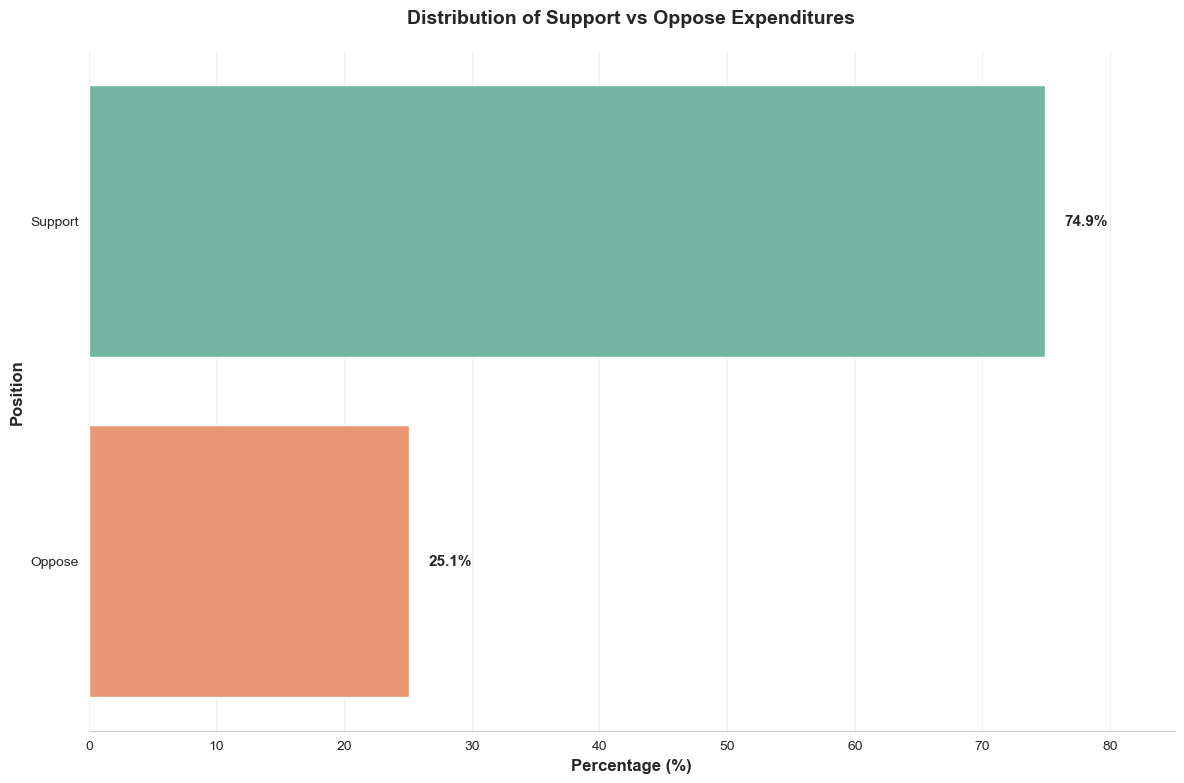

In [37]:
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

categories = ['Support', 'Oppose'] 
values = [74.9, 25.1]

plot_df = pd.DataFrame({
    'Category': categories,
    'Percentage': values
})

plt.figure(figsize=(12, 8))

ax = sns.barplot(data=plot_df, y='Category', x='Percentage', 
                palette='Set2', orient='h')

plt.title('Distribution of Support vs Oppose Expenditures', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Percentage (%)', fontsize=12, fontweight='bold')
plt.ylabel('Position', fontsize=12, fontweight='bold')

for i, (category, value) in enumerate(zip(categories, values)):
    ax.text(value + 1.5, i, f'{value}%', 
            va='center', ha='left', fontweight='bold', fontsize=11)

ax.grid(axis='x', alpha=0.3)
ax.set_axisbelow(True)
sns.despine(left=True, bottom=False)

plt.xlim(0, 85)

# Adjust layout and save
plt.tight_layout()
plt.savefig('images/support_oppose_seaborn.png', dpi=300, bbox_inches='tight')
plt.show()


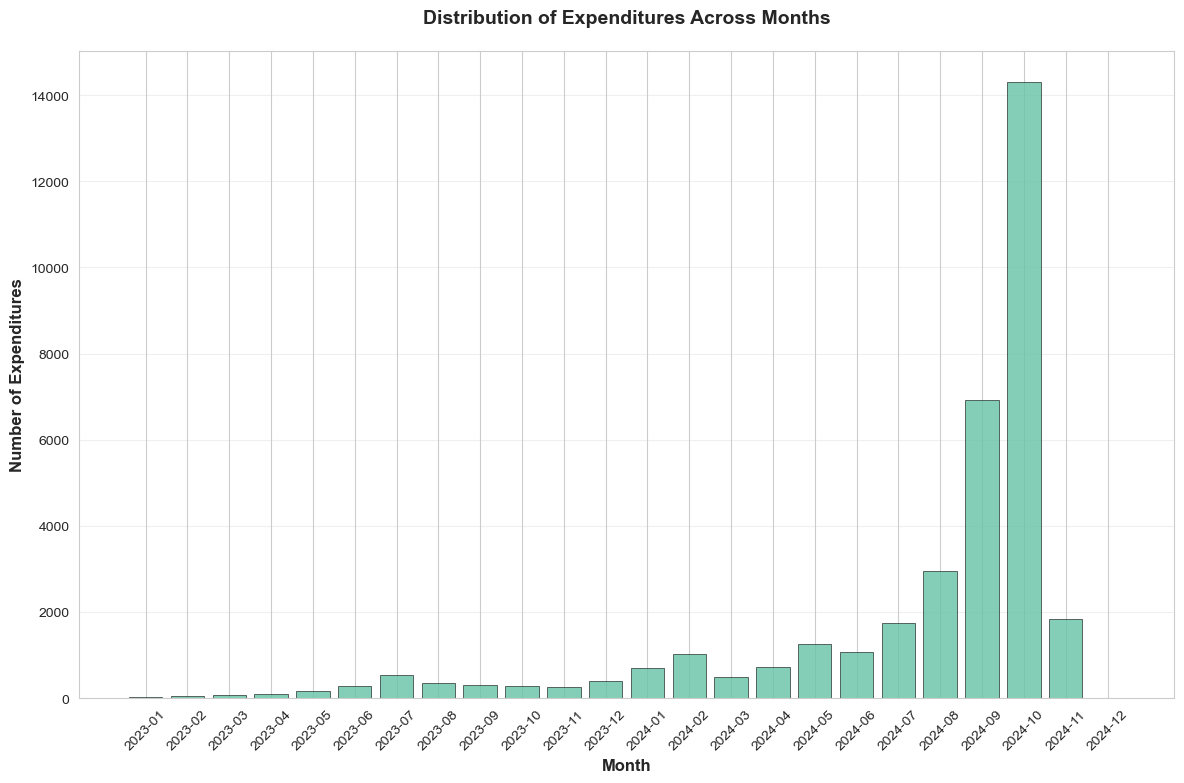

In [38]:
if 'exp_month' in df.columns:
    plt.figure(figsize=(12, 8))
    monthly_counts = df['exp_month'].value_counts().sort_index()
    
    colors = sns.color_palette('Set2', len(monthly_counts))
    plt.bar(range(len(monthly_counts)), monthly_counts.values, 
            color=colors[0], alpha=0.8, edgecolor='black', linewidth=0.5)
    
    plt.xlabel('Month', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Expenditures', fontsize=12, fontweight='bold')
    plt.title('Distribution of Expenditures Across Months', 
              fontsize=14, fontweight='bold', pad=20)
    plt.xticks(range(len(monthly_counts)), monthly_counts.index, rotation=45)
    
    plt.grid(axis='y', alpha=0.3)
    plt.gca().set_axisbelow(True)
    
    plt.tight_layout()
    plt.savefig('images/expenditure_by_party.png', dpi=300, bbox_inches='tight')
    plt.show()

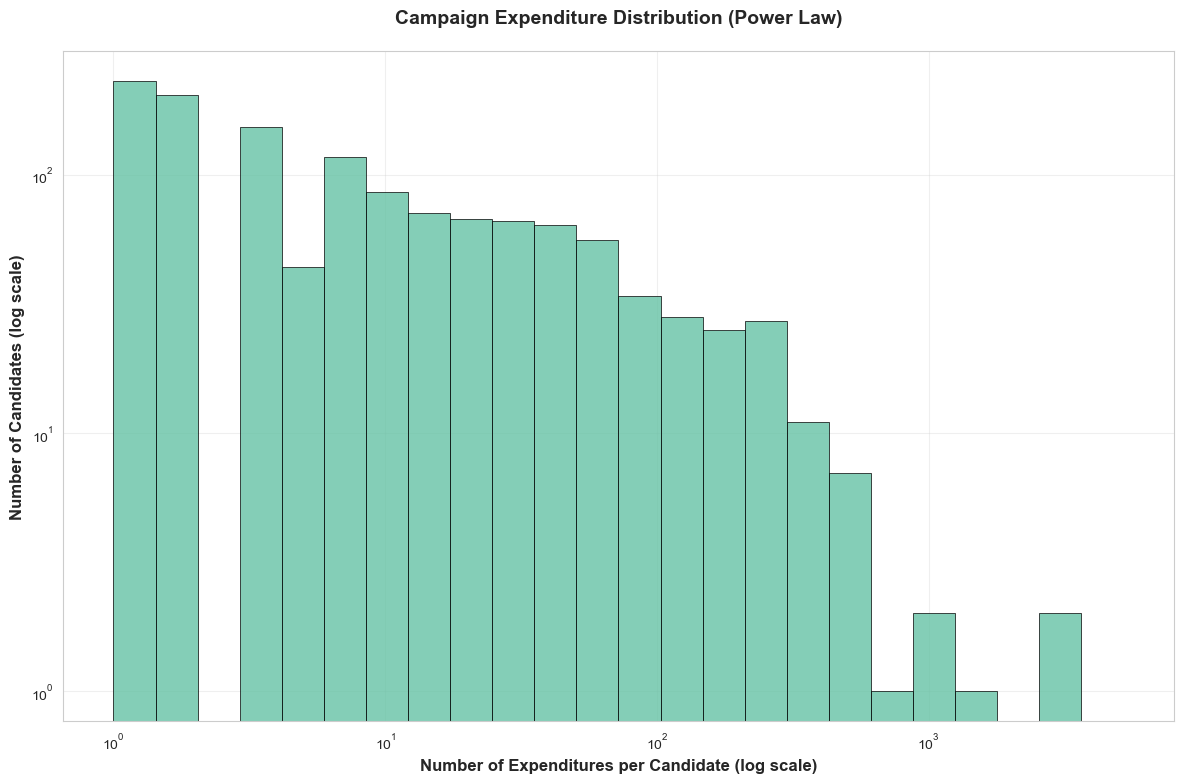

In [39]:
expenditures_per_candidate = df['cand_name'].value_counts()

plt.figure(figsize=(12, 8))
log_bins = np.logspace(0, np.log10(expenditures_per_candidate.max()), 25)

colors = sns.color_palette('Set2', 1)
sns.histplot(expenditures_per_candidate, bins=log_bins, alpha=0.8, 
             color=colors[0], edgecolor='black', linewidth=0.5)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Expenditures per Candidate (log scale)', 
           fontsize=12, fontweight='bold')
plt.ylabel('Number of Candidates (log scale)', 
           fontsize=12, fontweight='bold')
plt.title('Campaign Expenditure Distribution (Power Law)', 
          fontsize=14, fontweight='bold', pad=20)

plt.grid(True, alpha=0.3)
plt.gca().set_axisbelow(True)

plt.tight_layout()
plt.savefig('images/expenditure_amounts_by_party_enhanced.png', dpi=300, bbox_inches='tight')
plt.show()

AI assistance: Claude (Anthropic); prompts: "I am trying to capture a power law distribution in plotting campaign expenditure data - looking at Candidates and the count of expenditures... What would be a nice way to plot this as it tails off quickly from here. There are 1,323 entries. I would like to use seaborn. I am thinking a displot and would like some guidance on setting up bins to properly capture this" and "Explain this graph to me"; used for: generating Python code for power law visualization with logarithmic binning and seaborn, and explaining the resulting graph interpretation; changes: adapted the provided code examples to my specific dataset and selected the log-log scale approach; verification: tested the code with my campaign expenditure data, confirmed the power law pattern matches the theoretical expectations, and validated the graph interpretation against the raw data statistics.

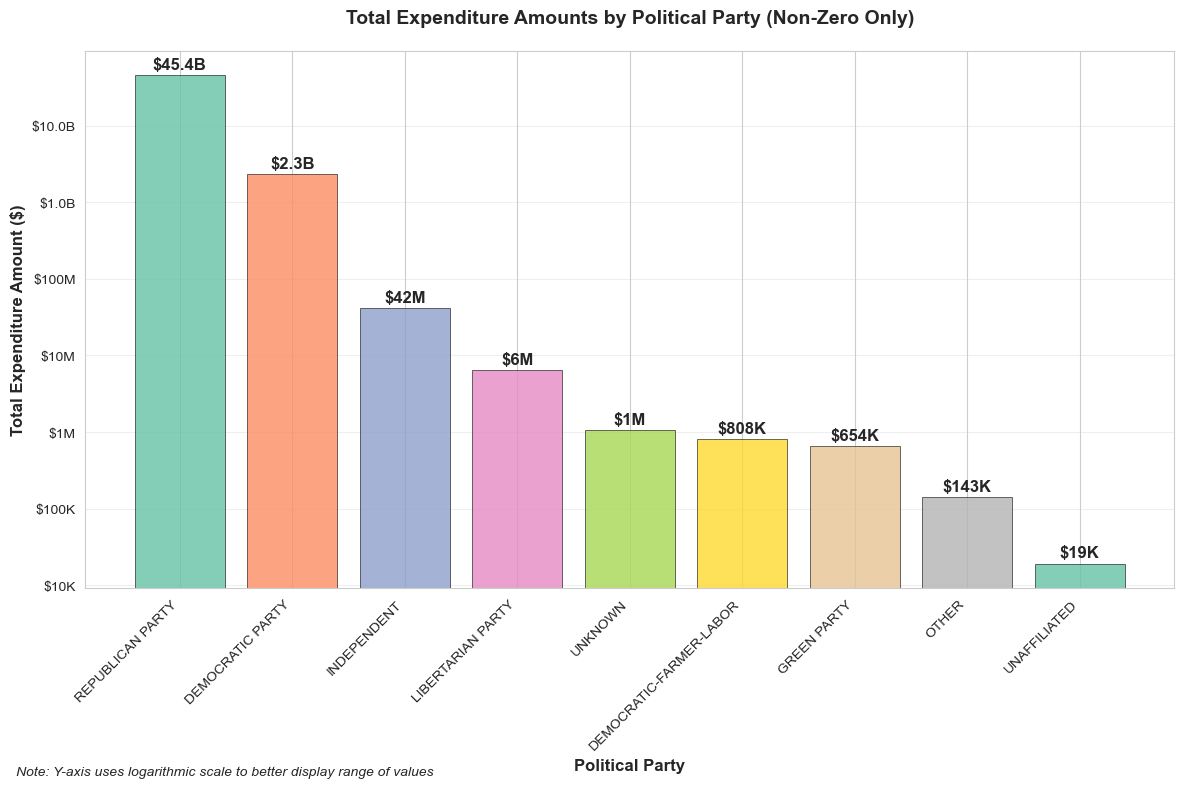

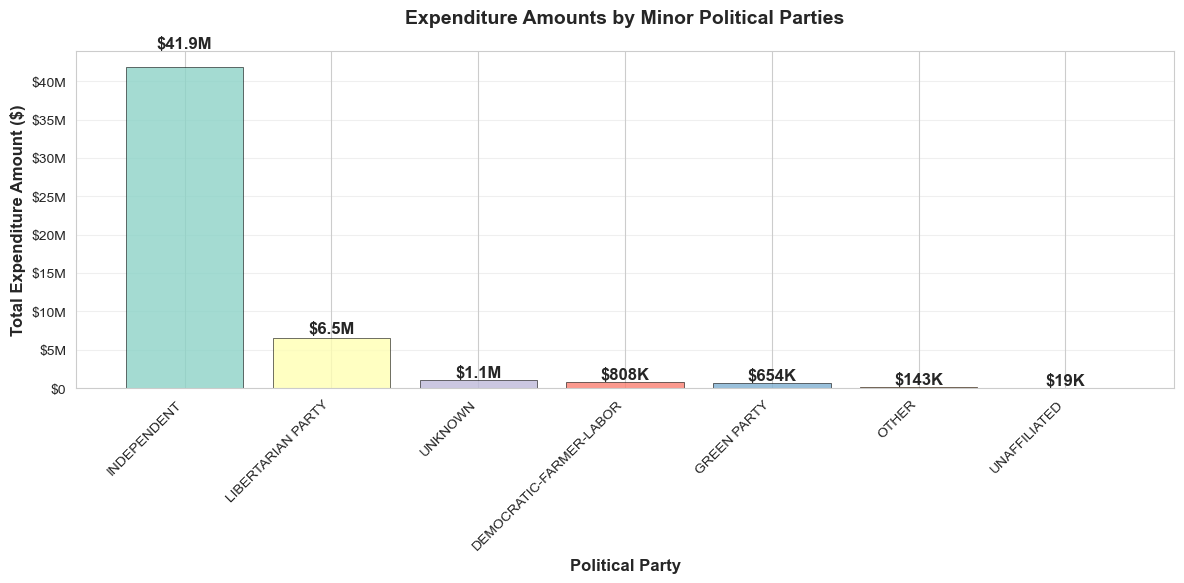

In [40]:
plt.figure(figsize=(12, 8))

party_expenditures = df.groupby('cand_pty_aff')['exp_amo'].sum().sort_values(ascending=False)

party_expenditures_filtered = party_expenditures[party_expenditures > 0]

colors = sns.color_palette('Set2', len(party_expenditures_filtered))

bars = plt.bar(range(len(party_expenditures_filtered)), party_expenditures_filtered.values, 
               color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)

plt.xlabel('Political Party', fontsize=12, fontweight='bold')
plt.ylabel('Total Expenditure Amount ($)', fontsize=12, fontweight='bold')
plt.title('Total Expenditure Amounts by Political Party (Non-Zero Only)', 
          fontsize=14, fontweight='bold', pad=20)

plt.xticks(range(len(party_expenditures_filtered)), party_expenditures_filtered.index, 
           rotation=45, ha='right')

plt.yscale('log')

def format_currency(x, p):
    if x >= 1e9:
        return f'${x/1e9:.1f}B'
    elif x >= 1e6:
        return f'${x/1e6:.0f}M'
    elif x >= 1e3:
        return f'${x/1e3:.0f}K'
    else:
        return f'${x:.0f}'

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_currency))

plt.grid(axis='y', alpha=0.3)
plt.gca().set_axisbelow(True)

for i, (party, amount) in enumerate(party_expenditures_filtered.items()):
    if amount >= 1e9:
        label = f'${amount/1e9:.1f}B'
    elif amount >= 1e6:
        label = f'${amount/1e6:.0f}M'
    elif amount >= 1e3:
        label = f'${amount/1e3:.0f}K'
    else:
        label = f'${amount:.0f}'
    
    plt.text(i, amount * 1.1, label, ha='center', va='bottom', fontweight='bold')

plt.figtext(0.02, 0.02, 'Note: Y-axis uses logarithmic scale to better display range of values', 
            fontsize=10, style='italic')

plt.tight_layout()
plt.savefig('images/expenditure_by_party_improved.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 6))

minor_parties = party_expenditures_filtered.iloc[2:]

if len(minor_parties) > 0:
    colors_minor = sns.color_palette('Set3', len(minor_parties))
    
    bars = plt.bar(range(len(minor_parties)), minor_parties.values, 
                   color=colors_minor, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    plt.xlabel('Political Party', fontsize=12, fontweight='bold')
    plt.ylabel('Total Expenditure Amount ($)', fontsize=12, fontweight='bold')
    plt.title('Expenditure Amounts by Minor Political Parties', 
              fontsize=14, fontweight='bold', pad=20)
    
    plt.xticks(range(len(minor_parties)), minor_parties.index, rotation=45, ha='right')
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_currency))
    
    plt.grid(axis='y', alpha=0.3)
    plt.gca().set_axisbelow(True)
    
    # Add value labels
    for i, (party, amount) in enumerate(minor_parties.items()):
        if amount >= 1e6:
            label = f'${amount/1e6:.1f}M'
        elif amount >= 1e3:
            label = f'${amount/1e3:.0f}K'
        else:
            label = f'${amount:.0f}'
        
        plt.text(i, amount * 1.05, label, ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('images/minor_party_expenditures.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No minor parties with expenditures found for separate visualization.")

AI assistance: Claude (Anthropic Sonnet 4); prompts: "How can we improve this plot so that it better captures spending by party."; used for code optimization and data visualization improvements; changes: generated Python code with logarithmic scaling, filtered zero values, improved currency formatting, and created dual-chart approach; verification: reviewed code logic, formatting functions, and visualization principles for accuracy.